In [9]:
from skimage.transform import resize
import numpy as np
import random
from skimage.filters import gaussian
from tqdm import tqdm
import matplotlib.cm as cm


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, ):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap_back =  heatmap
    heatmap = tf.maximum(heatmap, 0)
    cam_max = tf.math.reduce_max(heatmap)
    
    if cam_max != 0:
        heatmap = heatmap / cam_max
        
    if(np.percentile(heatmap, 99) == np.min(heatmap)):
        heatmap = (heatmap_back - np.min(heatmap_back)) / (np.max(heatmap_back) - np.min(heatmap_back))

    
    return heatmap.numpy()

In [10]:
#Importing Necessary Libraries.

from PIL import Image
import numpy as np
import pandas as pd 
import os
import re
import cv2
from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4024)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import lime
from lime import lime_image
from matplotlib import pylab as P

import saliency.core as saliency
import glob2

from datetime import datetime, timedelta
from RISE_tf.explain_image import RISE


tf.__version__

'2.5.0'

In [11]:
INPUT_DIR = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/EVAL_TESTE/XRAY_EVAL/"
OUTPUT_DIR = "./OUT/CUSTOM-XRAY-TRUE/"
MODEL = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/1TRAIN_NEW_VGG_CUSTOM/CUSTOMCNN/X-RAY/CUSTOM-CNN-XRAY-TRUE/baseline_model.h5"
INPUT_FILES = glob2.glob(os.path.join(INPUT_DIR, "*/*.jpeg"))
EVAL_SIZE = len(INPUT_FILES)

In [12]:
def image_generator(directory, res, batch_size=1):
    test_datagen = ImageDataGenerator()
    image_generator = test_datagen.flow_from_directory(
            directory,
            target_size=(res, res),
            color_mode= 'rgb',
            batch_size= batch_size,  
            class_mode= 'categorical',
            shuffle= False, 
            seed= 1337)
    return image_generator

In [13]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [14]:
def save_greyscale(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file),  cv2.cvtColor(mask*255,cv2.COLOR_GRAY2RGB))

def save_rgb(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
def save_heat(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    plt.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin = 0, vmax = 255)
    
def save_heat_image(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray')
    
def save_lime(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin= mask.min(), vmax=mask.max())
    
def save_blur(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap=P.cm.gray, vmin=0, vmax=1)
    
from matplotlib import pylab as P
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, file,  title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap=P.cm.gray, vmin=0, vmax=1)

def ShowHeatMap(im, file, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap='grey')
    
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img

def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img, ax=False, norm=diverging_norm, show_axis=False, grayscale=False, cmap='gray', title='', fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [15]:
conv_layer_str = "conv2d_2"

model_path = MODEL
m = tf.keras.models.load_model(model_path)
m.summary()
conv_layer = m.get_layer(conv_layer_str)
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

Found 50 images belonging to 2 classes.
1/1 [==============================] - 1s 779ms/step - loss: 0.5148 - accuracy: 0.8600
Test Loss:  0.5147534012794495
Test Accuracy:  0.8600000143051147


<ipython-input-14-538294728fb7>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=fig_size)


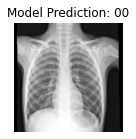

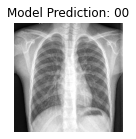

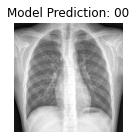

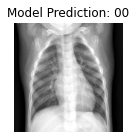

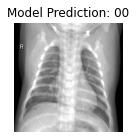

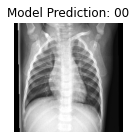

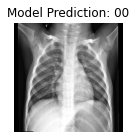

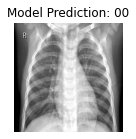

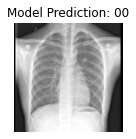

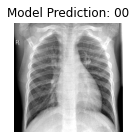

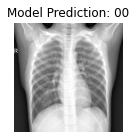

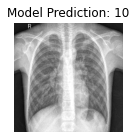

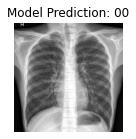

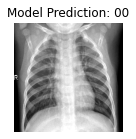

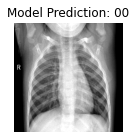

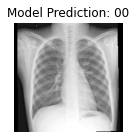

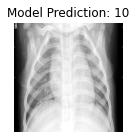

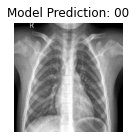

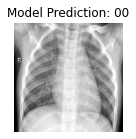

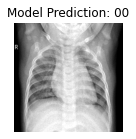

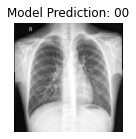

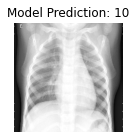

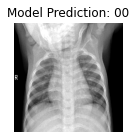

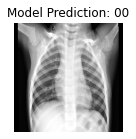

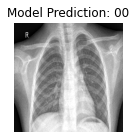

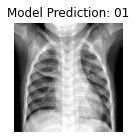

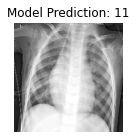

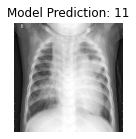

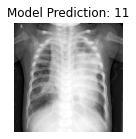

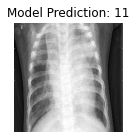

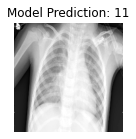

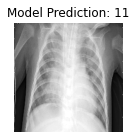

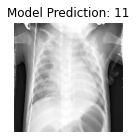

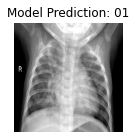

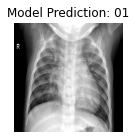

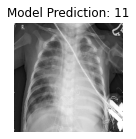

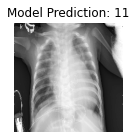

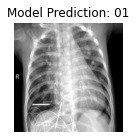

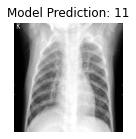

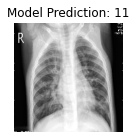

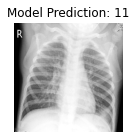

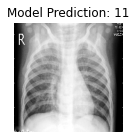

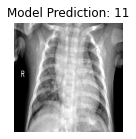

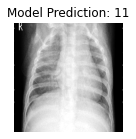

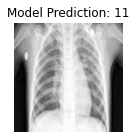

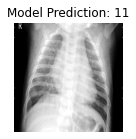

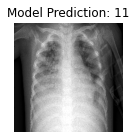

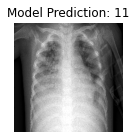

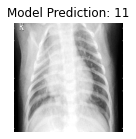

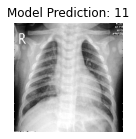

In [16]:
generator = image_generator(INPUT_DIR, 224, batch_size=EVAL_SIZE)
X, Y = generator.next()
logits = m.predict(X[:EVAL_SIZE])
predictions = logits.argmax(axis=1)

(eval_loss, eval_accuracy) = m.evaluate(generator, batch_size=EVAL_SIZE, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

for i in range(EVAL_SIZE):
    plot_single_img(X[i],
                    fig_size=(2,2),
                    title="Model Prediction: "+str(predictions[i]) +str(generator.classes[i]))

In [17]:
def vanilla_gradient(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    gradient_saliency = saliency.GradientSaliency()
    vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Vanilla Elapsed time:', timedelta(seconds=elapsed_seconds))
    return gradient_saliency, vanilla_mask_3d

def smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency):
    start_time = datetime.now()
    
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args, stdev_spread=0.15,nsamples=50,magnitude=False)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_mask_3d

def integrated_gradients_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    integrated_gradients = saliency.IntegratedGradients()
    baseline = np.zeros(im.shape)
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
      im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('IG Elapsed time:', timedelta(seconds=elapsed_seconds))
    return integrated_gradients, vanilla_integrated_gradients_mask_3d

def guided_IGS_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    guided_ig = saliency.GuidedIG()
    baselineGuided = np.zeros(im.shape)
    guided_ig_mask_3d = guided_ig.GetMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baselineGuided, max_dist=1.0, fraction=0.5)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Guided Elapsed time:', timedelta(seconds=elapsed_seconds))
    return guided_ig_mask_3d

def blur_IG_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    blur_ig = saliency.BlurIG()
    blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Blur Elapsed time:', timedelta(seconds=elapsed_seconds))
    return blur_ig_mask_3d

def smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients):
    start_time = datetime.now()
    
    baseline = np.zeros(im.shape)
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_integrated_gradients_mask_3d

def grad_cam_func(img, m, conv_layer, prediction_class):
    start_time = datetime.now()
    gradcam = make_gradcam_heatmap(np.array([img]), m, conv_layer, pred_index=prediction_class)
    heatmap = np.uint8(255 * gradcam)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Grad Cam Elapsed time:', timedelta(seconds=elapsed_seconds))
    return jet_heatmap

def RISE_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = RISE()
    heatmaps, masks = explainer.explain(im, m)
    heatmap = heatmaps[prediction_class]
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Rise Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

def XRAI_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    xrai_object = saliency.XRAI()
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('XRAI Elapsed time:', timedelta(seconds=elapsed_seconds))
    return xrai_attributions

def LIME_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = lime_image.LimeImageExplainer(verbose=True)
    explanation = explainer.explain_instance(im.astype('double'), m.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(prediction_class, positive_only=False, num_features=5, hide_rest=True)
    dict_heatmap = dict(explanation.local_exp[prediction_class])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('LIME Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

In [18]:
def return_mask_dicts(im, im_org, call_model_function, call_model_args, prediction_class, m):

    output_masks_dict = {}
    
    #Original
    #output_masks_dict["Original"] = im_org

    # Vanilla Gradient mask.
    #gradient_saliency, vanilla_mask_3d = vanilla_gradient(im, call_model_function, call_model_args)
    #output_masks_dict["Gradient"] = vanilla_mask_3d
    
    # Smooth Gradient mask.
    #output_masks_dict["SmoothGrad"] = smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency) 

    # Smooth Input-Grad.
    #output_masks_dict["Input-Grad"] = np.multiply(vanilla_mask_3d, im)

    #IntegratedGradients
    #integrated_gradients, vanilla_integrated_gradients_mask_3d = integrated_gradients_func(im, call_model_function, call_model_args)
    #output_masks_dict["IntegratedGradients"] = vanilla_integrated_gradients_mask_3d

    # Compute the Guided IG mask.
    #output_masks_dict["GuidedIG"] = guided_IGS_func(im, call_model_function, call_model_args)

    # Compute the vanilla mask and the Blur IG mask.
    #output_masks_dict["BlurIG"] = blur_IG_func(im, call_model_function, call_model_args)

    # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
    #output_masks_dict["IGSmoothGrad"] = smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients)

    #GradCAM
    output_masks_dict["GradCam"] = grad_cam_func(im, m, conv_layer_str, prediction_class)

    #RISE
    #output_masks_dict["RISE"] = RISE_func(im, m, prediction_class)

    # Compute XRAI attributions with default parameters
    #output_masks_dict["XRAI"] = XRAI_func(im, call_model_function, call_model_args)

    #LIME
    #output_masks_dict["LIME"] = LIME_func(im, m, prediction_class)

    return output_masks_dict

In [19]:
results = []
logits = predictions
for i in range(EVAL_SIZE):
    call_model_args = {class_idx_str: logits[i]}
    nome = generator.filenames[i]
    results = return_mask_dicts(X[i], X[i], call_model_function, call_model_args, logits[i], m)
    for k, v in results.items():
        if(k == "Original"):
            mask_abs_norm = v
            mask_no_abs_norm = v
            mask_0_1_norm = v
        mask_abs_norm = abs_grayscale_norm(v)
        mask_no_abs_norm = diverging_norm(v)
        mask_0_1_norm = normalize_image(v)
        
        path= nome.split("/")[1].split(".")[0]+".png"
        save_lime(Path(OUTPUT_DIR+k), path, mask_abs_norm)

Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.6932105754426675
Prediction_local [0.32271499]
Right: 0.2501274
Intercept 0.3067893983718433
Prediction_local [0.67728504]
Right: 0.7498727
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:22
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.150585076752027
Prediction_local [0.32028996]
Right: 0.004786546
Intercept -0.15058505534917815
Prediction_local [0.67971001]
Right: 0.9952134
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:22
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.0881642370866298
Prediction_local [0.19381048]
Right: 0.009572093
Intercept -0.08816423618447866
Prediction_local [0.80618952]
Right: 0.99042785
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.6338489518934569
Prediction_local [0.2653139]
Right: 0.015317871
Intercept 0.36615104527105835
Prediction_local [0.7346861]
Right: 0.9846821
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.8820743414410868
Prediction_local [0.217183]
Right: 0.1009715
Intercept 0.11792567900952838
Prediction_local [0.78281698]
Right: 0.8990285
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.7118820450253469
Prediction_local [0.21061817]
Right: 0.02052832
Intercept 0.28811794716302314
Prediction_local [0.78938184]
Right: 0.9794717
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.25545147239874544
Prediction_local [0.49545222]
Right: 0.4699066
Intercept 0.7445485189702817
Prediction_local [0.5045478]
Right: 0.53009343
LIME Elapsed time: 0:00:11
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5571401926708766
Prediction_local [0.29828237]
Right: 0.20571525
Intercept 0.44285979012481874
Prediction_local [0.70171764]
Right: 0.79428476
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.9035436998304043
Prediction_local [0.51503064]
Right: 0.476855
Intercept 0.09645630519591822
Prediction_local [0.48496935]
Right: 0.5231449
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.007563379388156
Prediction_local [0.22137414]
Right: 0.009109341
Intercept -0.007563371209776848
Prediction_local [0.77862586]
Right: 0.9908907
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.7216189629562129
Prediction_local [0.1737836]
Right: 0.03177196
Intercept 0.27838101746865185
Prediction_local [0.82621642]
Right: 0.9682281
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:22
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.08444080063435125
Prediction_local [0.36785324]
Right: 0.49348968
Intercept 0.9155591955490321
Prediction_local [0.63214676]
Right: 0.5065103
LIME Elapsed time: 0:00:13
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.857133605959858
Prediction_local [0.00676428]
Right: 0.001305797
Intercept 0.14286637842802064
Prediction_local [0.99323574]
Right: 0.99869424
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.0300664432828441
Prediction_local [0.04408937]
Right: 0.00061337196
Intercept -0.03006646113313899
Prediction_local [0.95591065]
Right: 0.99938667
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.423674537103812
Prediction_local [-0.01361737]
Right: 2.4903313e-05
Intercept 0.5763254515353843
Prediction_local [1.01361738]
Right: 0.9999751
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.8662769618670643
Prediction_local [0.32989709]
Right: 0.1632023
Intercept 0.1337230369269749
Prediction_local [0.67010291]
Right: 0.83679765
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.6394852171685611
Prediction_local [-0.12402609]
Right: 4.9654614e-06
Intercept 0.36051478412652943
Prediction_local [1.12402608]
Right: 0.999995
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:19
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.6980626392664457
Prediction_local [0.46190883]
Right: 0.007552533
Intercept 0.3019373535471488
Prediction_local [0.53809117]
Right: 0.9924475
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.1704050631856877
Prediction_local [0.39718899]
Right: 0.2665982
Intercept -0.17040507607134606
Prediction_local [0.60281103]
Right: 0.7334019
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.39624758354489853
Prediction_local [0.13067858]
Right: 0.0114903925
Intercept 0.6037523987354154
Prediction_local [0.86932143]
Right: 0.9885096
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.8311842088021744
Prediction_local [0.40461697]
Right: 0.023436952
Intercept 0.16881579030722127
Prediction_local [0.59538303]
Right: 0.97656304
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12019698102995868
Prediction_local [0.26974426]
Right: 0.065922335
Intercept 0.8798030136041582
Prediction_local [0.73025574]
Right: 0.9340777
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.9091247029821952
Prediction_local [0.16079972]
Right: 0.13048661
Intercept 0.09087530682719869
Prediction_local [0.83920027]
Right: 0.8695134
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3987852432416885
Prediction_local [0.53392019]
Right: 0.109671496
Intercept 0.6012147684767275
Prediction_local [0.4660798]
Right: 0.89032847
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.0887805748997585
Prediction_local [0.31101944]
Right: 0.022856623
Intercept -0.08878058443958586
Prediction_local [0.68898057]
Right: 0.9771434
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4559847625054029
Prediction_local [0.52312876]
Right: 0.44116828
Intercept 0.5440152425251681
Prediction_local [0.47687123]
Right: 0.55883175
LIME Elapsed time: 0:00:13
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.09308539951606665
Prediction_local [0.28544415]
Right: 0.038562734
Intercept 0.9069146000819286
Prediction_local [0.71455585]
Right: 0.9614372
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1771443800959761
Prediction_local [0.18780952]
Right: 0.00014123185
Intercept 0.8228556311642984
Prediction_local [0.81219047]
Right: 0.99985874
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.45955170931382205
Prediction_local [0.18195946]
Right: 0.007934086
Intercept 0.5404482559766433
Prediction_local [0.81804058]
Right: 0.99206597
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.21347896501144753
Prediction_local [0.24032632]
Right: 0.00011489458
Intercept 0.7865210335438549
Prediction_local [0.75967368]
Right: 0.9998851
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2433082718382601
Prediction_local [-0.01954436]
Right: 4.3340027e-05
Intercept 0.7566917420573317
Prediction_local [1.01954435]
Right: 0.9999566
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.061386212046645725
Prediction_local [0.01252622]
Right: 0.00060043996
Intercept 0.9386137918736076
Prediction_local [0.98747378]
Right: 0.99939954
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2977363067621084
Prediction_local [-0.06188747]
Right: 1.9425146e-05
Intercept 0.7022636974568266
Prediction_local [1.06188746]
Right: 0.99998057
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.16431262277073147
Prediction_local [0.25673153]
Right: 0.08738335
Intercept 0.8356873755480468
Prediction_local [0.74326847]
Right: 0.91261667
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4573512388370031
Prediction_local [0.38055038]
Right: 0.08778593
Intercept 0.5426487681680028
Prediction_local [0.61944962]
Right: 0.91221404
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.24956192236060032
Prediction_local [0.10137019]
Right: 0.0059851
Intercept 0.7504380799743398
Prediction_local [0.89862981]
Right: 0.9940149
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20589136978097605
Prediction_local [0.21577588]
Right: 0.0007112493
Intercept 0.794108645180772
Prediction_local [0.7842241]
Right: 0.9992887
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.22256622577201346
Prediction_local [0.39347009]
Right: 0.48911726
Intercept 0.7774337875430668
Prediction_local [0.6065299]
Right: 0.51088274
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.9242394968840812
Prediction_local [-0.18841794]
Right: 0.0002962343
Intercept 0.07576051152213958
Prediction_local [1.18841793]
Right: 0.9997037
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.08475191951899488
Prediction_local [-0.02517108]
Right: 4.560822e-06
Intercept 0.9152480575482401
Prediction_local [1.02517111]
Right: 0.99999547
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.22689567840731856
Prediction_local [0.50807249]
Right: 0.20873557
Intercept 0.7731043323882918
Prediction_local [0.4919275]
Right: 0.7912644
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:21
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.49275113051050273
Prediction_local [-0.03175055]
Right: 0.0006804626
Intercept 0.5072488697511195
Prediction_local [1.03175055]
Right: 0.99931955
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:19
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5030395873957252
Prediction_local [0.62835186]
Right: 0.40776575
Intercept 0.4969604089664933
Prediction_local [0.37164814]
Right: 0.5922343
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:19
XRAI Elapsed time: 0:00:13


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.49682387311912046
Prediction_local [-0.21858003]
Right: 1.2977042e-06
Intercept 0.5031761426818059
Prediction_local [1.21858001]
Right: 0.9999987
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.13267737511566857
Prediction_local [0.08114352]
Right: 0.0040081497
Intercept 0.8673226149959055
Prediction_local [0.91885649]
Right: 0.9959919
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3904803747020977
Prediction_local [-0.1687297]
Right: 2.0294787e-07
Intercept 0.6095196342394121
Prediction_local [1.16872969]
Right: 0.99999976
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:22
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2636656828576347
Prediction_local [0.14996284]
Right: 0.010665212
Intercept 0.7363343218422508
Prediction_local [0.85003716]
Right: 0.98933476
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:14


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.25565347890394197
Prediction_local [0.14413494]
Right: 0.010665212
Intercept 0.7443465310699627
Prediction_local [0.85586505]
Right: 0.98933476
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:05
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:19
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2207612537564756
Prediction_local [-0.0868997]
Right: 3.7640754e-07
Intercept 0.7792387345895875
Prediction_local [1.08689971]
Right: 0.99999964
LIME Elapsed time: 0:00:11
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:10
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:20
XRAI Elapsed time: 0:00:15


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept -0.010443644431922583
Prediction_local [0.3727337]
Right: 0.04363716
Intercept 1.0104436268198977
Prediction_local [0.62726631]
Right: 0.9563629
LIME Elapsed time: 0:00:12
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
